In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftn, ifftn
from scipy.signal import correlate2d

from opformer import TransformerOperator
from kernels import Kernels

def GRF(alpha, beta, gamma, N, num_samples=10):
    xi = np.random.randn(num_samples, N, N)
    K1, K2 = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
    freq_sq = (K1**2 + K2**2)
    coef = alpha**0.5 * (4*np.pi**2 * freq_sq + beta)**(-gamma/2)
    L = N * coef * xi
    L[:, 0, 0] = 0  # enforce mean 0
    f_spatials = np.real(ifftn(L, norm='forward', axes=(-2, -1)))
    return f_spatials

def np_conv(kernel, img):
    kh, kw = kernel.shape
    H, W = img.shape

    # Compute asymmetric 'same' padding for even-sized kernels
    ph_top = kh // 2
    ph_bottom = kh - ph_top - 1
    pw_left = kw // 2
    pw_right = kw - pw_left - 1

    # Circular (wrap-around) padding
    padded = np.pad(
        img,
        ((ph_top, ph_bottom), (pw_left, pw_right)),
        mode='wrap'
    )

    # Perform cross-correlation (equivalent to conv2d with no flipping in PyTorch)
    # If you need strict convolution, flip the kernel:
    kernel_flipped = np.flip(kernel, axis=(0, 1))

    # Use 'valid' to get result of original size due to pre-padding
    result = correlate2d(padded, kernel_flipped, mode='valid')

    return result

def make_simple_learnable_operator_dataset(kernel, num_samples=25, H=64, W=64, sigma=1.0, seed=0):
    # Sample 5 random basis pairs (f_i, g_i)
    alpha, beta, gamma, N = 1.0, 1.0, 4.0, H
    num_bases = 5

    basis_fs = GRF(alpha, beta, gamma, N, num_bases)
    basis_gs = GRF(alpha, beta, gamma, N, num_bases)

    # Precompute convolutions (k * g_i)
    g_convs = np.array([np_conv(kernel, g) for g in basis_gs])

    # Sample new input functions
    fs = GRF(alpha, beta, gamma, N, num_samples)

    # Compute operator outputs:
    # O(f) = sum_{i=1}^5 <f, f_i> * (k * g_i)
    Ofs = np.zeros((num_samples, H, W))
    for j in range(num_samples):
        for i in range(num_bases):
            inner = np.sum(fs[j] * basis_fs[i])
            Ofs[j] += inner * g_convs[i]

    return fs, Ofs

H, W = 64, 64
kernel_maps = Kernels(H, W)

true_kernel_name = "gaussian"
true_kernel = kernel_maps.get_kernel(true_kernel_name)

# Generate data
icl_num_samples = 50
f, Of = make_simple_learnable_operator_dataset(
    true_kernel, 
    num_samples=icl_num_samples
)

f_train  = f[:-1]
Of_train = Of[:-1]
f_test   = f[-1]
Of_test  = Of[-1]

In [5]:
import torch

device = "cuda"
im_size = (64, 64)

def construct_Z(f_test):
    f_full = np.concatenate([f[:-1], np.expand_dims(f_test, axis=0)], axis=0)
    Z = np.expand_dims(np.concatenate([f_full, Of], axis=1), axis=0)
    Z_pt = torch.from_numpy(Z).to(device).to(torch.float32)
    Z_pt[:,-1,im_size[0]:] = 0
    return Z_pt

r = 2 # 5e-1
num_layers = 250

kernel_names = kernel_maps.available_kernels()
kernel_to_preds, kernel_to_errors = {}, {}
for kernel_name in ["gaussian"]:
    opformer = TransformerOperator(num_layers=num_layers, im_size=im_size, kernel=kernel_maps.get_kernel(kernel_name), icl_lr=-r, icl_init=True).to(device)

    y_idx  = -1
    Z_test = construct_Z(f[y_idx])

    _, preds = opformer(Z_test)
    test_preds = np.array([pred[0,-1,64:,:,0] for pred in preds]) # just extract bottom right for test prediction
    errors = np.array([np.linalg.norm(test_pred + Of[y_idx]) for test_pred in test_preds])

    kernel_to_preds[kernel_name]  = test_preds
    kernel_to_errors[kernel_name] = errors

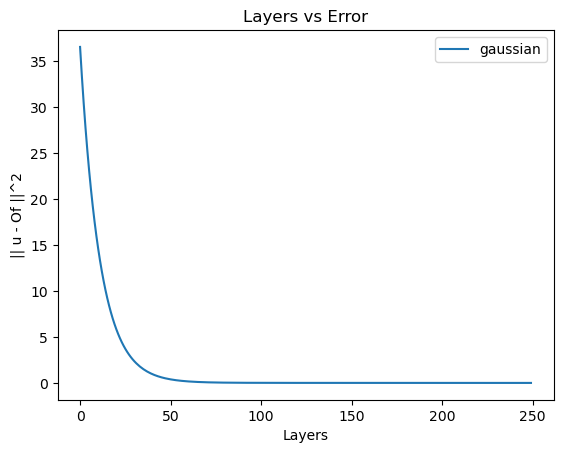

In [6]:
plt.title("Layers vs Error")
plt.xlabel("Layers")
plt.ylabel("|| u - Of ||^2")

for kernel_name in ["gaussian"]:
    if kernel_name == "mexican_hat":
        continue
    plt.plot(kernel_to_errors[kernel_name], label=kernel_name)
    
plt.legend()

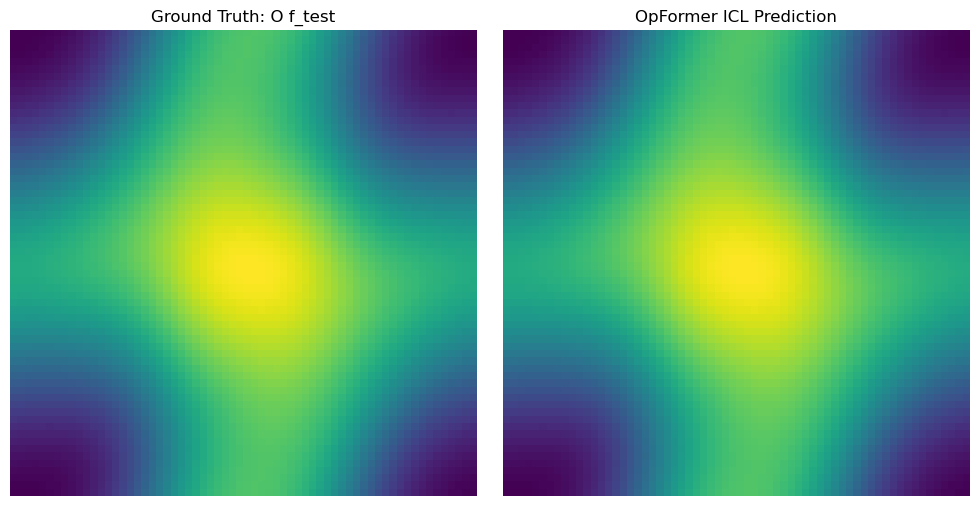

In [104]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(Of[y_idx], cmap='viridis')
axes[0].set_title("Ground Truth: O f_test")
axes[0].axis('off')

axes[1].imshow(-test_preds[-1], cmap='viridis')
axes[1].set_title("OpFormer ICL Prediction")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [44]:
for layer_idx in range(num_layers):
    # Check if y^i_l+1 = y_l + TF_l(x^i)
    pred = preds[layer_idx][0,...,0]
    y_i    = pred[y_idx,64:]
    y_pred = pred[-1,64:]

    print(f"y {y_idx} | Layer {layer_idx} -- {np.isclose(Of[y_idx] + y_pred, y_i).all()}")

    # Check if y^i_l+1 = y^i_l + \sum_j y^j_l h(x^j, x)
    delta = np.zeros(Of[y_idx].shape)
    if layer_idx == 0:
        prev_layer = Of
    else:
        prev_layer = preds[layer_idx-1][0,:,64:,:,0]
    
    for i in range(icl_num_samples-1):
        kxx   = np.sum(f[i] * f[y_idx]) / (64 * 64)
        ly    = r * np_conv(true_kernel, prev_layer[i])
        delta += kxx * ly

    exp_y = prev_layer[y_idx] + delta

    print(f"y = y + \sum_i y_i h(x_i, x) -- {np.isclose(exp_y, y_i).all()}")
print("----------------------------------")

y 0 | Layer 0 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 1 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 2 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 3 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 4 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 5 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 6 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 7 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 8 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 9 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 10 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 11 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 12 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 13 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 14 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 15 -- True
y = y + \sum_i y_i h(x_i, x) -- True
y 0 | Layer 16 -- True
y = y + \sum_i y_i h(x_i, x

KeyboardInterrupt: 

In [5]:
import torch.nn.functional as F

def pt_conv(kernel, img):
    # Compute asymmetric 'same' padding for even-sized kernels
    _, _, kh, kw = kernel.shape
    ph_top = kh // 2
    ph_bottom = kh - ph_top - 1
    pw_left = kw // 2
    pw_right = kw - pw_left - 1

    # Apply circular padding manually
    value_padded = F.pad(
        img.unsqueeze(0),  # [1, H, W]
        (pw_left, pw_right, ph_top, ph_bottom),  # (L, R, T, B)
        mode='circular'
    )
    
    return F.conv2d(
        value_padded.unsqueeze(0),
        kernel,  # [1, 1, kh, kw]
        padding=0,
    )

In [12]:
kernel            = kernel_maps.get_kernel("gaussian")
pt_conv_result    = pt_conv(torch.from_numpy(true_kernel).unsqueeze(0).unsqueeze(0), torch.from_numpy(Of[y_idx]))
pt_conv_result_np = r * pt_conv_result[0,0].cpu().detach().numpy()

In [ ]:
import torch.nn.functional as F

def pt_conv(kernel, img):
    # Compute asymmetric 'same' padding for even-sized kernels
    _, _, kh, kw = kernel.shape
    ph_top = kh // 2
    ph_bottom = kh - ph_top - 1
    pw_left = kw // 2
    pw_right = kw - pw_left - 1

    # Apply circular padding manually
    value_padded = F.pad(
        img.unsqueeze(0),  # [1, H, W]
        (pw_left, pw_right, ph_top, ph_bottom),  # (L, R, T, B)
        mode='circular'
    )
    
    return F.conv2d(
        value_padded.unsqueeze(0),
        kernel,  # [1, 1, kh, kw]
        padding=0,
    )

In [ ]:

def construct_Z(f_test):
    f_full = np.concatenate([f[:-1], np.expand_dims(f_test, axis=0)], axis=0)
    Z = np.expand_dims(np.concatenate([f_full, Of], axis=1), axis=0)
    Z_pt = torch.from_numpy(Z).to(device).to(torch.float32)
    Z_pt[:,-1,im_size[0]:] = 0
    return Z_pt

device = "cuda"
im_size = (64, 64)

Z_pt = construct_Z(f_test)

kernel_names = kernel_maps.available_kernels()
kernel_to_preds, kernel_to_errors = {}, {}
for kernel_name in [kernel_names[0]]:
    opformer = TransformerOperator(num_layers=350, im_size=im_size, kernel=kernel_maps.get_kernel(kernel_name), icl_lr=5e-2, icl_init=True).to(device)
    _, preds = opformer(Z_pt)

    kernel_to_preds[kernel_name]  = np.array([pred[0,-1,64:,:,0] for pred in preds]) # just extract bottom right for test prediction
    kernel_to_errors[kernel_name] = np.array([np.sum((test_pred - Of_test) ** 2) for test_pred in kernel_to_preds[kernel_name]])

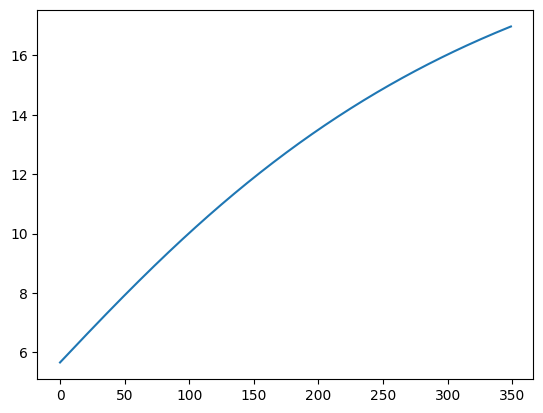

In [14]:
plt.plot(kernel_to_errors["gaussian"])

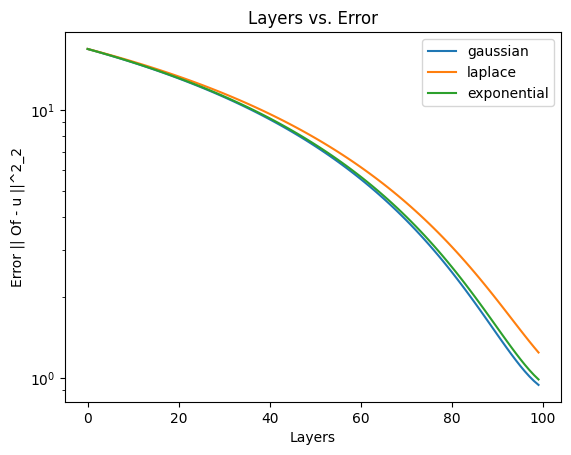

In [7]:
for kernel_name in kernel_to_errors:
    plt.semilogy(kernel_to_errors[kernel_name], label=kernel_name)

plt.xlabel("Layers")
plt.ylabel("Error || Of - u ||^2_2")
plt.title("Layers vs. Error")
plt.legend()

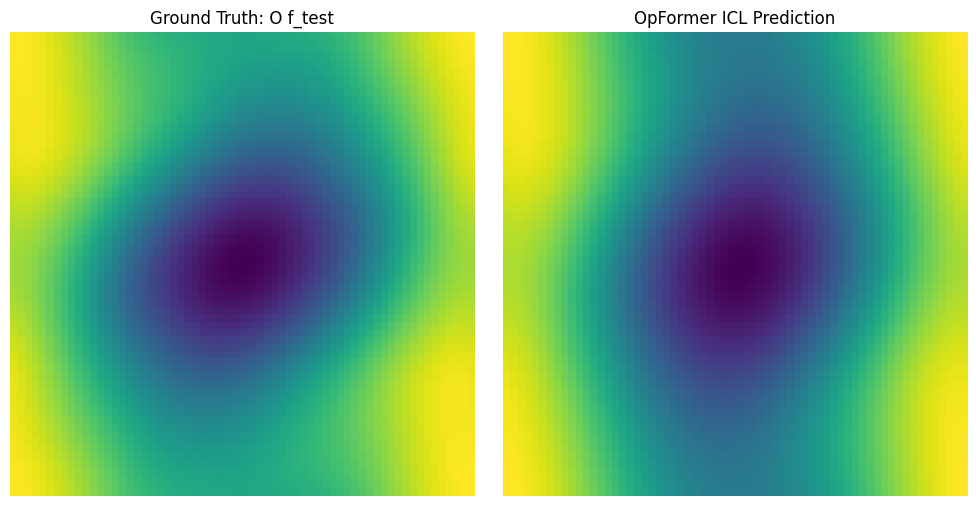

(None, np.float64(120.46352620544961))

In [8]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(Of_test, cmap='viridis')
axes[0].set_title("Ground Truth: O f_test")
axes[0].axis('off')

axes[1].imshow(kernel_to_preds["laplace"][-1,0], cmap='viridis')
axes[1].set_title("OpFormer ICL Prediction")
axes[1].axis('off')

plt.tight_layout()
plt.show(), losses[-1]

# Debugging

In [8]:
import torch

def construct_Z(f_test):
    f_full = np.concatenate([f[:-1], np.expand_dims(f_test, axis=0)], axis=0)
    Z = np.expand_dims(np.concatenate([f_full, Of], axis=1), axis=0)
    Z_pt = torch.from_numpy(Z).to(device).to(torch.float32)
    Z_pt[:,-1,im_size[0]:] = 0
    return Z_pt

r = 1e-1
num_layers = 10

opformer = TransformerOperator(num_layers=num_layers, im_size=im_size, kernel=kernel_maps.get_kernel(kernel_name), icl_lr=r, icl_init=True).to(device)

y_idx = 0

for y_idx in [0,1,2]:
    Z_test = construct_Z(f[y_idx])

    # confirm setup
    for i in range(Z_test.shape[1]-1):
        print(f"x same: {np.isclose(Z_test[0,i,:64].cpu().detach().numpy(),  f[i]).all()}")
        print(f"y same: {np.isclose(Z_test[0,i,64:].cpu().detach().numpy(), Of[i]).all()}")
    
    print(f"y test set: {np.isclose(Z_test[0,-1,:64].cpu().detach().numpy(), f[y_idx]).all()}")
    print(f"y test zeroed: {(Z_test[0,-1,64:].cpu().detach().numpy() == 0).all()}")

    _, preds = opformer(Z_test)

    for layer_idx in range(num_layers):
        pred = preds[layer_idx][0,...,0]
        y_i    = pred[y_idx,64:]
        y_pred = pred[-1,64:]

        print(f"y {y_idx} | Layer {layer_idx} -- {np.isclose(Of[y_idx] + y_pred, y_i).all()}")
    print("---------------------------")

x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
y test set: True
y test zeroed: True
y 0 | Layer 0 -- True
y 0 | Layer 1 -- True
y 0 | Layer 2 -- True
y 0 | Layer 3 -- True
y 0 | Layer 4 -- True
y 0 | Layer 5 -- True
y 0 | Layer 6 -- True
y 0 | Layer 7 -- True
y 0 | Layer 8 -- True
y 0 | Layer 9 -- True
---------------------------
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
y test set: True
y test zeroed: True
y 1 | Layer 0 -- True
y 1 | Layer 1 -- True
y 1 | Layer 2 -- True
y 1 | Layer 3 -- True
y 1 | Layer 4 -- True
y 1 | Layer 5 -- True
y 1 | Layer 6 -- True
y 1 | Layer 7 -- True
y 1 | Layer 8 -- True
y 1 | Layer 9 -- True
---------------------------
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
x same: True
y same: True
y test set: True
y test zeroed: True
y 2 | Layer 0 -- True
y 2 | Layer 1 -- True
y 2 | Layer 2 -- True
y 2 | Layer 3 -

In [ ]:
# manual GD used for debugging
# Precompute inner products <f_train[i], f_train[j]>
T, H, W = f_train.shape
gram = np.array([
    [np.sum(f_train[i] * f_train[j]) for j in range(T)]
    for i in range(T)
])

# Flatten training outputs
Y = Of_train.reshape(T, -1)  # shape (T, H*W)

# Solve (G + lambda I) alpha = Y for each pixel
G_reg = gram
alpha = np.linalg.solve(G_reg, Y)  # shape (T, H*W)

test_inner_prods = np.array([np.sum(f_test * f_train[i]) for i in range(T)])  # shape (T,)
Of_test_pred_flat = test_inner_prods @ alpha  # shape (H*W,)

alpha_gd = np.zeros((T, H * W))
lr = 1e-6
num_steps = 50

losses = []

for step in range(num_steps):
    residual = gram @ alpha_gd - Y
    grad     = gram.T @ residual
    alpha_gd -= lr * grad

    loss = 0.5 * np.linalg.norm(residual)**2
    losses.append(loss)

# Predict using GD solution
Of_test_pred_gd_flat = test_inner_prods @ alpha_gd
Of_test_pred_gd = Of_test_pred_gd_flat.reshape(H, W)

torch.Size([1, 5, 128, 64])